# MATH 693A Advanced Numerical Methods: Computational Optimization HW 5
###  By: Will McGrath


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Problem 1: Implement BFGS

### Below is code which generates initial conditions for the BFGS method. For the initial condition, 18-dimensional initial condition returned by rosenbrock 2Nd(x,-1). 

### Compare against full Newton optimization — count number of “outer iterations” $x_k \rightarrow x_{k+1}$ as well as “inner iterations” (linesearches/backtracking).

In [59]:
def rosenbrock_2Nd_test(x, order):
    # initial condition in R18
    if order == -1:
        xn = np.array([1, 1])
        x0easy = np.array([1.2, 1.2])
        x0e2 = (xn + x0easy) / 2 
        x0e3 = (xn + x0e2) / 2 
        x0e4 = (xn + x0e3) / 2 
        x0hard = np.array([-1.2, 1])
        x0h2   = (xn + x0hard) / 2
        x0h3   = (xn + x0h2)  / 2
        x0h4   = (xn + x0h3) / 2
        x0h5   = 2 * x0hard

        R = np.array([x0easy, x0e2, x0e3, x0e4, x0hard, x0h2, x0h3, x0h4, x0h5])

        return R

    rb2d = lambda x: 100 * (x[1] - x[0]**2)**2 + (1 - x[0]**2)
    rb2d_x = lambda x: -400 * (x[1] - x[0]**2) * x[0] - 2 + 2 * x[0]
    rb2d_xx = lambda x: 1200 * x[0]**2 - 400 * x[1] + 2
    rb2d_xy = lambda x: -400 * x[0]
    rb2d_y = lambda x: 200 * x[1] - 200 * x[0]**2
    rb2d_yy = lambda x: 200
    rb2d_grad = lambda x: np.array([rb2d_x(x), rb2d_y(x)])
    rb2d_hess = lambda x: np.array([[rb2d_xx(x), rb2d_xy(x)],[rb2d_xy(x), rb2d_yy(x)]])

    # 1D versions
    # the function and derivatives needed to compute the
    # gradient and the hessian
    if order == 0: 
        return rb2d(x)

    elif order == 1:
        return rb2d_grad(x)

    elif order == 2:
        return rb2d_hess(x)

    else:
        print(f'Cannot compute derviates of order {order}')

In [60]:
# rosenbrock function provided by the professor
def rosenbrock_2Nd(x, order):
    
    if order == -1:
        xN = np.array([1.0,1.0])
        x0easy = np.array([1.2,1.2])
        x0e2 = .5* (xN + x0easy)
        x0e3 = .5*(xN + x0e2)
        x0e4 = .5*(xN + x0e3)
        x0hard = np.array([-1.2, 1.0])
        x0h2 = .5*(xN + x0hard)
        x0h3 = .5*(xN + x0h2)
        x0h4 = .5*(xN + x0h3)
        x0h5 = 2*x0hard
        R =np.array([x0easy, x0e2, x0e3, x0e4, x0hard, x0h2,x0h3,x0h4,x0h5])
        return R

    nx = len(x)

    rb2d = lambda x: (100*(x[1] - x[0]**2)**2 + (1-x[0]**2))
    rb2d_x = lambda x: (-400*(x[1]-x[0]**2)* x[0]- 2 +2*x[0])
    rb2d_xx = lambda x: (1200*x[0]**2 -400*x[1] +2 )
    rb2d_xy = lambda x: (-400*x[0])
    rb2d_y = lambda x :(200*x[1] - 200*x[0]**2)
    rb2d_yy = lambda x: (200)
    rb2d_grad = lambda x: np.array([rb2d_x(x), rb2d_y(x)])
    rb2d_hess = lambda x: np.array([[rb2d_xx(x), rb2d_xy(x)],[rb2d_xy(x), rb2d_yy(x)]])

    if order == 0:
        R= np.zeros(1)
        for k in range(0, nx, 2):
            R = R + rb2d([x[k], x[k+1]])
        return R

    if order == 1:
        R =np.zeros(nx)
        for k in range(0,nx,2):
            grad_k = rb2d_grad([x[k],x[k+1]])
            R[k] = grad_k[0]
            R[k+1]= grad_k[1]
        return R
    elif order == 2: 
        R = np.zeros((nx,nx))
        for k in range(0,nx,2):
            hess_k = rb2d_hess([x[k],x[k+1]])
            #print hess_k
            R[k][k]= hess_k[0][0]
            R[k+1][k+1] = hess_k[1][1]
            R[k][k+1]= hess_k[0][1]
            R[k+1][k] = hess_k[1][0]
        return R
    else:   
        print("Cannot compute derivative of order:  " + str(order))

        

## Part A, B, C, D, E

### 1A) Present the value of the following in a table for BFGS for each outer iteration:
- Number of iterations
- $f(x)$
- $\alpha$
- $\nabla{f(x_k)}$

### 1B) Total number of outer iterations

### 1C) Total number of inner iterations

### 1D) Repeat 1a, b, and c for Newton method. Discuss your observations

### 1E) Check the Quasi-Newton convergence criteria (from lecture #5)
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ \lim_{k\to\infty} \frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|} $
- Present the value of $ \frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|} $ for each outer iteration in a table 
- Plot $ \log_{10}(\frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|})$ against iteration


In [61]:
# backtracking = wolfe condition = line search 
def bfgs_method(x0, eps=10**(-4)):
    inner_iter_list, k_list, xk_list, fx_list, alpha_list, grad_list, convergence_list = [], [], [], [], [], [], []
    k = 0
    c = 10**(-2)
    rho = 0.5
    xk = x0
    grad_fk = rosenbrock_2Nd(x0, 1) # grad(x0)
    I = np.eye(len(x0), dtype=int) # identity matrix I
    Hk = I

    while np.linalg.norm(grad_fk) > eps:
        # search direction
        pk = -np.dot(Hk, grad_fk)

        # backtracking 
        # tries to find optimum alpha so doesn't move to far
        inner_iter = 0 
        alpha_k = 1
        while (rosenbrock_2Nd(xk + alpha_k * pk, 0) > rosenbrock_2Nd(xk, 0) + alpha_k * c * np.dot(pk, grad_fk)):
            alpha_k *= rho
            inner_iter += 1
        
        if k == 0:
            inner_iter_list.append(np.nan)
            xk_list.append(x0)
            k_list.append(0)
            fx_list.append(rosenbrock_2Nd(x0, 0))
            alpha_list.append(1)
            grad_list.append(rosenbrock_2Nd(x0, 1))
            convergence_list.append(np.nan)
            
        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1
        grad_fkp1 = rosenbrock_2Nd(xkp1,1)
        yk = grad_fkp1 - grad_fk
        grad_fk = grad_fkp1
        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])

        num = np.linalg.norm(np.dot((Hk - rosenbrock_2Nd(xk, 2)), pk))
        denom = np.linalg.norm(pk)
        convergence = num / denom

        k += 1
        xk_list.append(xk)
        k_list.append(k)
        fx_list.append(rosenbrock_2Nd(xk, 0))
        alpha_list.append(alpha_k)
        grad_list.append(grad_fk)
        inner_iter_list.append(inner_iter)
        convergence_list.append(convergence)

    bfgs_df = pd.DataFrame([[k_list, inner_iter_list, xk_list, fx_list, alpha_list, grad_list, convergence_list]], 
    columns=['outer_iteration', 'inner_iteration', 'xbar', 'f(x)', 'alpha', 'grad_f(x)', 'Quasi_Newton_Convergence']).explode(
        ['outer_iteration', 'inner_iteration', 'xbar', 'f(x)', 'alpha', 'grad_f(x)', 'Quasi_Newton_Convergence']).reset_index(drop=True)

    bfgs_df = bfgs_df[:-1]
    return bfgs_df

In [62]:
rosenbrock_2Nd(0, -1)

array([[ 1.2  ,  1.2  ],
       [ 1.1  ,  1.1  ],
       [ 1.05 ,  1.05 ],
       [ 1.025,  1.025],
       [-1.2  ,  1.   ],
       [-0.1  ,  1.   ],
       [ 0.45 ,  1.   ],
       [ 0.725,  1.   ],
       [-2.4  ,  2.   ]])

### $x_0 = [1.2, 1.2]$

In [63]:
bfgs_df_1 = bfgs_method([1.2, 1.2])
bfgs_df_1

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.2, 1.2]",[5.32],1,"[115.6, -48.0]",NaN
1,1,10,"[1.087109375, 1.246875]",[0.24158036023611157],0.000977,"[-28.120284295082076, 13.013641357421875]",1124.516646
2,2,2,"[0.9959647725949852, 1.0166730224733447]",[0.0691975851648278],0.25,"[-9.85903620336432, 4.945438844632832]",90.147544
3,3,50,"[0.995964772594985, 1.016673022473344]",[0.06919758516482713],0.0,"[-9.859036203364228, 4.945438844632804]",66.231078
4,4,9,"[0.9787745049103602, 0.9607287052276449]",[0.04274530748150332],0.001953,"[-1.1109492704887334, 0.5458347530248204]",167.221487
5,5,46,"[0.9787745049103602, 0.9607287052276448]",[0.042745307481503264],0.0,"[-1.1109492704886899, 0.545834753024792]",165.627008
6,6,0,"[0.9792812470037081, 0.9593724870540806]",[0.04102273452000837],1,"[-0.1905727645287023, 0.0761452641886251]",714.072067
7,7,0,"[0.9794432981252615, 0.9592645587548139]",[0.0406910248116841],1,"[-0.023634067590701635, -0.008923097535245006]",962.491806
8,8,0,"[0.9795314713651537, 0.9594038896777732]",[0.04051870521922116],1,"[-0.010370300865993665, -0.015602743401956332]",90.082775
9,9,0,"[0.9816585445851176, 0.9631652680251315]",[0.03637033870919231],1,"[0.15502720142803827, -0.09764602636795416]",43.240794


In [64]:
bfgs_df_1['inner_iteration'].sum()

153

### Total number of outer iterations: 16

### Total number of inner iterations: 153

### Minimum: $x^* = [1,1]$

### $x_0 = [1.1, 1.1]$

In [65]:
bfgs_df_2 = bfgs_method([1.1, 1.1])
bfgs_df_2

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.1, 1.1]",[1.000000000000002],1,"[48.60000000000005, -22.0]",NaN
1,1,10,"[1.0525390625, 1.121484375]",[-0.08921742783611912],0.000977,"[-5.640057691931821, 2.7291793823242756]",1083.240983
2,2,46,"[1.0525390624999993, 1.121484374999998]",[-0.0892174278361196],0.0,"[-5.640057691931539, 2.7291793823241335]",59.658473
3,3,0,"[1.0678823355931206, 1.1399419201827405]",[-0.1403541270396187],1,"[0.31976613235516727, -0.08615249781556145]",282.494233
4,4,47,"[1.0678823355931206, 1.1399419201827403]",[-0.1403541270396187],0.0,"[0.3197661323552621, -0.08615249781558987]",20.959287
5,5,47,"[1.0678823355931206, 1.1399419201827403]",[-0.1403541270396187],0.0,"[0.3197661323552621, -0.08615249781558987]",NaN


In [66]:
bfgs_df_2['inner_iteration'].sum()

150

### Total number of outer iterations: 6

### Total number of inner iterations: 150

### Minimum: $x^* = [1,1]$

### $x_0 = [1.05, 1.05]$

In [67]:
bfgs_df_3 = bfgs_method([1.05, 1.05])
bfgs_df_3

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.05, 1.05]",[0.17312499999999986],1,"[22.15, -10.5]",NaN
1,1,10,"[1.028369140625, 1.06025390625]",[-0.056808236584847085],0.000977,"[-1.0583498807158542, 0.5421633720397949]",1046.726611
2,2,47,"[1.028369140625, 1.0602539062499998]",[-0.0568082365848472],0.0,"[-1.0583498807157627, 0.5421633720397665]",41.436149
3,3,51,"[1.028369140625, 1.0602539062499996]",[-0.05680823658484733],0.0,"[-1.0583498807156713, 0.5421633720397097]",160.513143
4,4,0,"[1.0628075971998705, 1.1135604716281517]",[-0.10396153412208364],1,"[6.927378498040172, -3.199903407522072]",151.42084
5,5,48,"[1.0628075971998703, 1.1135604716281515]",[-0.10396153412208392],0.0,"[6.927378498040075, -3.199903407522015]",143.716625
6,6,46,"[1.062807597199869, 1.1135604716281498]",[-0.10396153412208459],0.0,"[6.927378498039592, -3.1999034075218162]",155.797126
7,7,0,"[1.0512454226495713, 1.1032990340239257]",[-0.10478646092175217],1,"[0.8669164085885182, -0.363580923550046]",424.97584
8,8,45,"[1.0512454226495713, 1.1032990340239257]",[-0.10478646092175217],0.0,"[0.8669164085885182, -0.363580923550046]",NaN


In [68]:
bfgs_df_3['inner_iteration'].sum()

247

### Total number of outer iterations: 9

### Total number of inner iterations: 247

### Minimum: $x^* = [1,1]$

### $x_0 = [1.025, 1.025]$

In [69]:
bfgs_df_4= bfgs_method([1.025, 1.025])
bfgs_df_4

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.025, 1.025]",[0.015039062500000117],1,"[10.556250000000002, -5.125]",NaN
1,1,10,"[1.0146911621093748, 1.0300048828125]",[-0.029581611667834642],0.000977,"[-0.13569914047930398, 0.08134566992524128]",1025.14282
2,2,46,"[1.0146911621093748, 1.0300048828124997]",[-0.02958161166783466],0.0,"[-0.13569914047921383, 0.08134566992521286]",15.200861
3,3,48,"[1.0146911621093748, 1.0300048828124995]",[-0.02958161166783468],0.0,"[-0.13569914047912368, 0.08134566992515602]",157.463685
4,4,0,"[1.0159786200600012, 1.0317289541329258]",[-0.032189169301912346],1,"[0.22848907343531355, -0.09672045721970335]",188.936122
5,5,45,"[1.0159786200600012, 1.0317289541329258]",[-0.032189169301912346],0.0,"[0.22848907343531355, -0.09672045721970335]",NaN


In [70]:
bfgs_df_4['inner_iteration'].sum()

149

### Total number of outer iterations: 6

### Total number of inner iterations: 149

### Minimum: $x^* = [1,1]$

### $x_0 = [-1.2, 1]$

In [71]:
bfgs_df_5 = bfgs_method([-1.2, 1])
bfgs_df_5

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-1.2, 1]",[18.919999999999995],1,"[-215.59999999999997, -88.0]",NaN
1,1,10,"[-0.989453125, 1.0859375]",[1.164171440566422],0.000977,"[38.338030314445454, 21.384002685546847]",946.505385
2,2,3,"[-0.7723458059823386, 0.5705923983388312]",[0.4706958663723069],0.125,"[-11.55411709519772, -5.185129135935384]",114.413891
3,3,50,"[-0.7723458059823386, 0.5705923983388312]",[0.4706958663723069],0.0,"[-11.55411709519772, -5.185129135935384]",NaN


In [72]:
bfgs_df_5['inner_iteration'].sum()

63

### Total number of outer iterations: 4

### Total number of inner iterations: 63

### Minimum: $x^* = [1,1]$

### $x_0 = [-0.1, 1]$

In [73]:
bfgs_df_6 = bfgs_method([-0.1, 1])
bfgs_df_6

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-0.1, 1]",[98.99999999999999],1,"[37.4, 198.0]",NaN
1,1,7,"[-0.3921875, -0.546875]",[49.942280951142315],0.007812,"[-112.70449676513672, -140.13720703125]",321.845055
2,2,7,"[-0.04338358775090512, -0.6959452879456169]",[49.694429181567486],0.007812,"[-14.196470082748366, -139.56548472635149]",260.709209
3,3,0,"[-0.20892457746579182, 0.09785536936239136]",[1.2501783751778435],1,"[2.112127935328261, 10.841178058626344]",195.282522
4,4,0,"[-0.20030948806018697, 0.042029447859687326]",[0.9602392236849733],1,"[-2.2479385290625493, 0.38111137055062727]",199.692597
5,5,46,"[-0.20030948806018684, 0.042029447859687215]",[0.9602392236849733],0.0,"[-2.2479385290625538, 0.3811113705506166]",70.424936
6,6,51,"[-0.20030948806018675, 0.042029447859687166]",[0.9602392236849733],0.0,"[-2.2479385290625546, 0.38111137055061306]",39.005833
7,7,53,"[-0.20030948806018672, 0.04202944785968715]",[0.9602392236849733],0.0,"[-2.2479385290625546, 0.38111137055061306]",NaN


In [74]:
bfgs_df_6['inner_iteration'].sum()

164

### Total number of outer iterations: 8

### Total number of inner iterations: 164

### Minimum: $x^* = [1,1]$

### $x_0 = [0.45, 1]$

In [75]:
bfgs_df_7 = bfgs_method([0.45, 1])
bfgs_df_7

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[0.45, 1]",[64.39812500000001],1,"[-144.65, 159.5]",NaN
1,1,8,"[1.0150390625, 0.376953125]",[42.65647128002967],0.003906,"[265.3008631378413, -130.6702346801758]",1114.0045
2,2,6,"[0.5685647274405503, -0.24136728730428314]",[32.557792044689165],0.015625,"[127.54932361943078, -112.9266273187661]",104.496177
3,3,0,"[0.7755648980723641, 0.6399221006423631]",[0.5461178692939969],1,"[-12.368120577528133, 7.684237904073328]",230.985271
4,4,0,"[0.7765599719813459, 0.6061556066891216]",[0.3979219546496149],1,"[-1.4129879440318964, 0.6220433210905867]",386.199411
5,5,0,"[0.7784937442076751, 0.6059820744761159]",[0.3939479863425842],1,"[-0.42107913716950085, -0.014087058873840874]",608.700365
6,6,0,"[0.7818146460983141, 0.6098841130018432]",[0.3889481166662825],1,"[-0.014182088873144316, -0.2700055703977853]",94.881824
7,7,0,"[0.8019604378595756, 0.6376140091214572]",[0.35991371476499373],1,"[1.3767457734664803, -1.1053069540930096]",52.632624
8,8,0,"[0.8266998613728145, 0.6753205671623603]",[0.3231479455147435],1,"[2.335906394977565, -1.622418726294086]",29.864102
9,9,0,"[0.8610673247717731, 0.732517233079648]",[0.2665191754216881],1,"[2.794321158490786, -1.7839409419940182]",14.363132


In [76]:
bfgs_df_7['inner_iteration'].sum()

14

### Total number of outer iterations: 17

### Total number of inner iterations: 14

### Minimum: $x^* = [1,1]$

### $x_0 = [0.725, 1]$

In [77]:
bfgs_df_8 = bfgs_method([0.725, 1])
bfgs_df_8

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[0.725, 1]",[22.9775390625],1,"[-138.11875, 94.875]",NaN
1,1,9,"[0.99476318359375, 0.814697265625]",[3.067926670350836],0.001953,"[69.56586008137893, -34.971305161714554]",1035.798244
2,2,4,"[0.749587748465379, 0.4346999069211106]",[2.055641413090876],0.0625,"[37.63276884438948, -25.436377145657133]",21.101264
3,3,0,"[0.8521387548108207, 0.7320954387449032]",[0.2774057227710903],1,"[-2.3255106284198845, 1.1909962588734402]",154.149342
4,4,0,"[0.8562834796302594, 0.7339695463152802]",[0.26683457517911535],1,"[-0.5436840332824877, 0.14962976551507268]",456.847468
5,5,0,"[0.8634696912047775, 0.7443708647180416]",[0.25456627084684635],1,"[0.144528146095531, -0.24180858224642066]",64.627711
6,6,0,"[0.8886957376934026, 0.7849503181663695]",[0.2125525787728372],1,"[1.4942791330099834, -0.9659592056103179]",38.133204
7,7,0,"[0.9089436594072459, 0.8206145981410247]",[0.17691720895888136],1,"[1.8408242687188066, -1.1127955671221343]",13.398653
8,8,0,"[0.9442939503048142, 0.8876026675587954]",[0.10998043443988545],1,"[1.432847330894528, -0.8176794046951272]",0.409181
9,9,0,"[0.9643181880467038, 0.9292561705705612]",[0.07013312499596241],1,"[0.18066950814460125, -0.13067944542336818]",27.702639


In [78]:
bfgs_df_8['inner_iteration'].sum()

13

### Total number of outer iterations: 14

### Total number of inner iterations: 13

### Minimum: $x^* = [1,1]$

### $x_0 = [-2.4, 2]$

In [79]:
bfgs_df_9 = bfgs_method([-2.4, 2])
bfgs_df_9

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-2.4, 2]",[1409.0],1,"[-3616.4, -752.0]",NaN
1,1,10,"[1.1316406250000002, 2.734375]",[211.0625104351364],0.000977,"[-657.7923038244247, 290.7528991699218]",528.995794
2,2,9,"[1.4587270852793486, 1.8102823635100564]",[8.95924029755206],0.001953,"[186.23551184747302, -63.52046916350554]",1222.723845
3,3,0,"[1.3807032844235694, 1.9620286102433582]",[-0.5962367988832677],1,"[-29.993510910452645, 11.13741012506523]",1255.346271
4,4,0,"[1.3911575419023532, 1.9383237575792043]",[-0.9344166336980465],1,"[-0.8895508876506599, 0.6008902374813374]",1205.213245
5,5,0,"[1.3913512332085232, 1.9366242946895296]",[-0.9357995723401925],1,"[0.35636988716092466, 0.15320810773027915]",774.113047
6,6,42,"[1.3913512332085232, 1.9366242946895293]",[-0.9357995723401925],0.0,"[0.35636988716104856, 0.1532081077302223]",210.91156
7,7,42,"[1.3913512332085232, 1.9366242946895291]",[-0.9357995723401925],0.0,"[0.356369887161172, 0.1532081077302223]",NaN


In [80]:
bfgs_df_9['inner_iteration'].sum()

103

### Total number of outer iterations: 8

### Total number of inner iterations: 103

### Minimum: $x^* = [1,1]$

<br>

### Quasi-Newton convergence

In [91]:
# plots
def plot_convergence(all_df):
    plt.figure(figsize=(13, 7))
    for df in all_df:
        xbar_list = df['xbar'].to_list()
        converg_list = df['Quasi_Newton_Convergence'].to_list()
        indx_list = np.linspace(1, len(xbar_list), len(xbar_list))
        plt.plot(indx_list, converg_list)

    plt.xlabel('Iteration')
    plt.ylabel('Log of Quasi Newton Convergence')
    plt.title('Algorithm Convergence')
    plt.xticks(np.arange(0,21))
    plt.legend(["x0 = [1.2, 1.2]", "x0 = [1.1, 1.1]", "x_0 = [1.05, 1.05]", 
                "x_0 = [1.025, 1.025]", "x_0 = [-1.2, 1]", "x_0 = [-0.1, 1]",
                "x_0 = [0.45, 1]", "x_0 = [0.725, 1]", "x_0 = [-2.4, 2]"], loc=0)

    return None

In [92]:
# log plots
def plot_convergence_logy(all_df):
    plt.figure(figsize=(13, 7))
    for df in all_df:
        xbar_list = df['xbar'].to_list()
        converg_list = np.ma.log10(df['Quasi_Newton_Convergence'].to_list()).data
        indx_list = np.linspace(1, len(xbar_list), len(xbar_list))
        plt.plot(indx_list, converg_list)

    plt.xlabel('Iteration')
    plt.ylabel('Log of Quasi Newton Convergence')
    plt.title('Algorithm Convergence')
    plt.xticks(np.arange(0,21))
    plt.legend(["x0 = [1.2, 1.2]", "x0 = [1.1, 1.1]", "x_0 = [1.05, 1.05]", 
                "x_0 = [1.025, 1.025]", "x_0 = [-1.2, 1]", "x_0 = [-0.1, 1]",
                "x_0 = [0.45, 1]", "x_0 = [0.725, 1]", "x_0 = [-2.4, 2]"], loc=0)

    return None

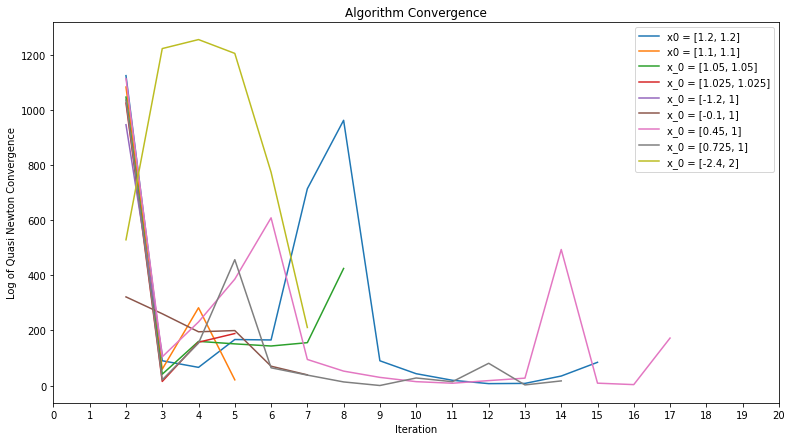

In [93]:
all_df = [bfgs_df_1, bfgs_df_2, bfgs_df_3, bfgs_df_4, bfgs_df_5, bfgs_df_6, bfgs_df_7, bfgs_df_8, bfgs_df_9]
plot_convergence(all_df)

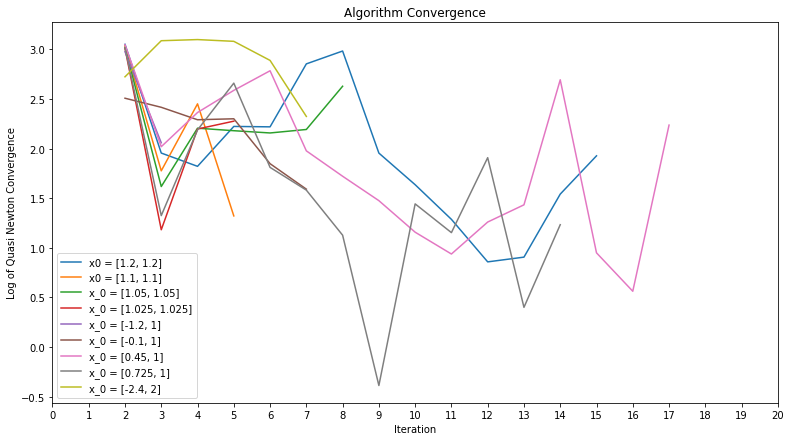

In [94]:
all_df = [bfgs_df_1, bfgs_df_2, bfgs_df_3, bfgs_df_4, bfgs_df_5, bfgs_df_6, bfgs_df_7, bfgs_df_8, bfgs_df_9]
plot_convergence_logy(all_df)

### We can see that, in general, the trend goes towards 0. Some trends have very few iterations making it hard to see the downward trend towards 0. However, if we look at $x_0 = [0.725, 1]$ we can see that the Quasi-Newton convergence criteria is true.

# Problem 2
### Construct matrices with different eigenvalue distributions (clustered and non- clustered) and apply the Conjugate Gradient (CG) method to them. Comment on whether the behavior can be explained from Theorem 5.5 in the text by Nocedal and Wright 2006. Generate a figure similar to Figure 5.4 in the text by Nocedal and Wright 2006.

### Theorem 5.5: If A has eigenvalues $\lambda_1 \leq \lambda_2 \leq... \leq \lambda_n$, we have that:
$
||\bar{x}_{k+1} - \bar{x}^*||^2_A \leq \left[\frac{\lambda_{n-k}-\lambda_1}{\lambda_{n-k}+\lambda_1}\right]^2 ||\bar{x}_{0} - \bar{x}^*||^2_A
$

$ 
\Rightarrow 0 \leq \left[\frac{\lambda_{n-k}-\lambda_1}{\lambda_{n-k}+\lambda_1}\right]^2||\bar{x}_{0} - \bar{x}^*||^2_A - ||\bar{x}_{k+1} - \bar{x}^*||^2_A
$

### A clustered eigenvalue distribution would be centered around some value R, while a non-clustered eigenvalue distribution would be uniform.

In [97]:
# congujate gradient method
def linear_conjugate_gradient(A, b, x0, stopping_criteria = 10**(-6)):
    xk = x0
    rk = np.dot(A, xk) - b # residuals
    pk = -rk
    k = 0 # count 
    xk_list, rk_norm_list, residual_list, iteration_list = [], [], [], []

    while np.linalg.norm(rk) > stopping_criteria:
        
        ap_k = np.dot(A, pk) 
        rk_rk = np.dot(rk, rk)
        alpha = rk_rk / np.dot(pk, ap_k)

        if k == 0:
            iteration_list.append(k)
            residual_list.append(rk)
            xk_list.append(xk)
            rk_norm_list.append(np.linalg.norm(rk))

        xk = xk + alpha * pk
        rk = rk + alpha * ap_k
        beta = np.dot(rk, rk) / rk_rk
        pk = -rk + beta * pk

        k += 1
        iteration_list.append(k)
        residual_list.append(rk)
        xk_list.append(xk)
        rk_norm_list.append(np.linalg.norm(rk))

    df = pd.DataFrame([[iteration_list, xk_list, residual_list, rk_norm_list]], 
        columns=['iteration', 'xbar', 'residuals', 'norm_residuals']
    ).explode(['iteration', 'xbar', 'residuals', 'norm_residuals']).reset_index(drop=True)

    return df

In [98]:
# hilbert matrix
def hilbert(n):
    matrix = []
    for i in range(1, n + 1):
        row = []
        for j in range(1, n + 1):
            row.append(1 / (i + j - 1))
        matrix.append(row)
        
    return matrix

def bn(n):
    return np.ones(n)

def xn(n):
    return np.zeros(n)

In [103]:
def calculate_R(hilbert_matrix, n, k, lambdas):
    A = sorted(np.linalg.eig(hilbert_matrix(n))[0])
    lambda_nk = A[n-k]
    lambda_1 = A[0]
    norm1 = np.linalg.norm(lambdas[0] - lambdas[-1])
    norm2 = np.linalg.norm(lambdas[k+1] - np.ones(n))
    R = (((lambda_nk - lambda_1) / (lambda_nk + lambda_1))**2 * norm1**2 - norm2**2)

    return R

-615894.3234298215
-18798127.186331406


Text(0, 0.5, '$\\log_{10}(R)$')

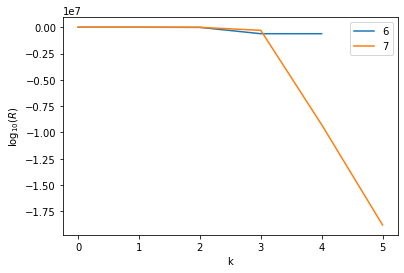

In [125]:
for n in [6,7]:
    df = linear_conjugate_gradient(hilbert(n),bn(n),xn(n))
    v = [calculate_R(hilbert, n, k1+1, df['xbar']) for k1 in range(n-1)]
    plt.plot(range(n-1),v,label=n)
    print(min(v))
plt.legend(loc=0)
plt.xlabel('k')
plt.ylabel('$\log_{10}(R)$')

Text(0, 0.5, 'Eigenvalues')

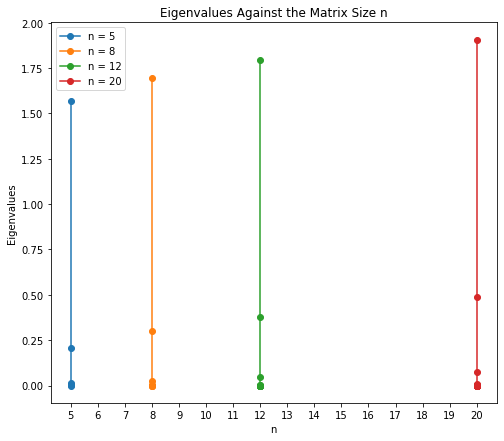

In [110]:
hilbert_matrix_list = [hilbert(n) for n in [5, 8, 12, 20]]
eigenvalue_list = [np.linalg.eig(e) for e in hilbert_matrix_list]
ones_list = [np.ones(n) * n for n in [5, 8, 12, 20]]

plt.figure(figsize=(8,7))
for i in range(len([5, 8, 12, 20])):
    plt.plot(ones_list[i], eigenvalue_list[i][0], marker='o')
plt.legend(['n = 5', 'n = 8', 'n = 12', 'n = 20'], loc=0);
plt.title('Eigenvalues Against the Matrix Size n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Eigenvalues')